In [1]:
%load_ext autoreload
%matplotlib inline
%autoreload 
import matplotlib.pyplot as plt
import sklearn
import pandas as pd
import numpy as np
import librosa
from librosa.core.spectrum import _spectrogram

In [2]:
# load data
df_resampled = pd.read_pickle("./data_for_modeling.pickle")

In [6]:
def fix_df(df_resampled_pre, th_spc, feature):
#     th_spc = th_spc * 60
#     columns = ['ピッチ (度)', 'Relative wind speed[m/s]', '相対風速 (m/s)_cos', '相対風速 (m/s)_sin', 'Speed[knot]', 'SPC_flux[mm]', 'mwp', 't2m', 'sst', 'swh', 'u10', 'v10', 'relative_wind_y', 'label', 'tp']
#     columns.extend([i+1 for i in range(30)])
#     columns.extend(['Relative_wind_direction[deg]', 'Relative wave direction[deg]', 'Speed[m/s]', 'encounter cycle', 'wave_length', 'ratio'])
    df_resampled_pre = df_resampled_pre.loc[:, feature]
#     print("1 ", df_resampled_pre.shape)
    
    df_resampled_hour = df_resampled_pre.asfreq("S")
#     print(df_resampled_hour)
    SPC_mean = df_resampled_hour['SPC_flux[mm]'].resample("min").mean()
    df_resampled_minute = df_resampled_hour.resample("min").nearest()
    df_resampled_minute["SPC_flux[mm]"] = SPC_mean
    print(df_resampled_minute.shape)
#     print("2 ", df_resampled_minute.shape)
#     print(df_resampled_minute)
    df_resampled_minute = df_resampled_minute.dropna()
    df_resampled_minute = df_resampled_minute[df_resampled_minute["SPC_flux[mm]"] >= 0]
    #plot_graph(df_resampled_minute, "SPC_flux[mm]", "Time[minute]", "Flux[mm]", "jare60_spc_after_reduced.png")
    print(df_resampled_minute.shape)
    df_resampled = df_resampled_minute
#     print("3 ", df_resampled.shape)
    del df_resampled_minute
    
    #plot_graph(df_resampled, "SPC_flux[mm]", "Time[minute]", "Flux[mm]", "jare60_spc.png")

    df_resampled['tp'] = df_resampled['tp'] * 60
    df_resampled = df_resampled[df_resampled['tp'] < (0.01 / 1000) / 60]
    #plot_graph(df_resampled, "SPC_flux[mm]", "Time[minute]", "Flux[mm]", "jare60_spc_after_reduced_by_tp.png")
    print(df_resampled.shape)
    df_copy = df_resampled.copy()
    # 飛沫データのラベリング
    spray_all = np.array(df_copy['SPC_flux[mm]'])
    #print(df_copy['SPC_flux[mm]'].describe())
    # 飛沫発生ならlabel=1, 飛沫0.0ならlabel=0
    spc_label = [1 if i > th_spc else 0 for i in spray_all]
    df_copy['label'] = spc_label
    #print(len(df_copy), len(df_copy[df_copy['label'] != 0.0]), len(df_copy[df_copy['label'] != 0.0]) / len(df_copy) * 100)
    df_copy = df_copy.rename(columns={'ピッチ (度)':'pitch', '相対風速 (m/s)_sin':'relative_wind_sin', '相対風速 (m/s)_cos':'relative_wind_cos'})
    return df_copy

In [7]:
import copy
th_spc = 1
df_resampled = pd.read_pickle("./data_for_modeling_jare60.pickle")

In [9]:
df_resampled.columns

Index([                     'ピッチ (度)',                  '中央Ax (m/s2)',
                        '中央Ay (m/s2)',                  '中央Az (m/s2)',
                          '南北速度 (kt)',               '右散水流量 (m3/min)',
                              '回転数調整',               '左散水流量 (m3/min)',
                          '東西速度 (kt)',     'Relative wind speed[m/s]',
                     '相対風速 (m/s)_cos',               '相対風速 (m/s)_sin',
                          '舵角　右舵 (度)',                    '舵角　左舵 (度)',
                        '船尾Ax (m/s2)',                  '船尾Ay (m/s2)',
                        '船尾Az (m/s2)',                  '船首Ax (m/s2)',
                        '船首Ay (m/s2)',                  '船首Az (m/s2)',
                        'Course[deg]',                  'Speed[knot]',
                       'SPC_flux[mm]',                          'mwp',
                                't2m',                          'sst',
                                'mwd',                           'tp',
      

In [41]:
for_modeling = ['swh', 'relative_wind_y', 'Speed[knot]', 'encounter cycle', 'Relative wind speed[m/s]']
#for_modeling.extend([i+1 for i in range(30)])
tmp = copy.deepcopy(for_modeling)
tmp.extend(["SPC_flux[mm]", "tp"])
df_copy = fix_df(df_resampled, th_spc, tmp)
#plot_graph(df_copy, "SPC_flux[mm]", "Time[minute]", "Flux[mm]", "jare60_spc_after_reduced.png")

(153531, 7)
(15736, 7)
(4361, 7)


# 1次元histgram

In [26]:
plt.rcParams['font.family'] = 'Times New Roman' # font familyの設定
plt.rcParams['mathtext.fontset'] = 'stix' # math fontの設定
plt.rcParams["font.size"] = 15 # 全体のフォントサイズが変更されます。
plt.rcParams['xtick.labelsize'] = 20 # 軸だけ変更されます。
plt.rcParams['ytick.labelsize'] = 20 # 軸だけ変更されます

plt.rcParams['xtick.direction'] = 'in' # x axis in
plt.rcParams['ytick.direction'] = 'in' # y axis in 
plt.rcParams['axes.linewidth'] = 1.0 # axis line width
plt.rcParams['axes.grid'] = True # make grid

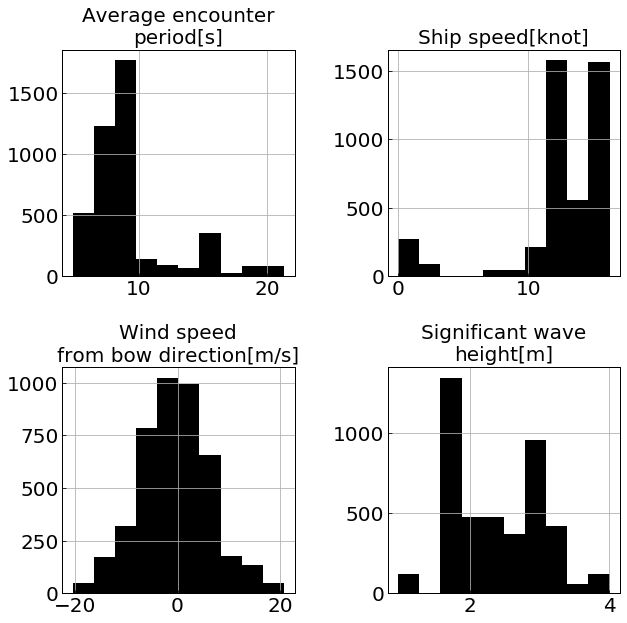

In [60]:
import itertools
for_hist_list = ['encounter cycle', 'Speed[knot]', 'relative_wind_y', 'swh']
for_hist_name = ['Average encounter\nperiod[s]', 'Ship speed[knot]',
                          'Wind speed\nfrom bow direction[m/s]', 'Significant wave\nheight[m]']

from matplotlib import rcParams
#import japanize_matplotlib


# 1次元histを描画
def draw_1dhist(df, cols, name, file_name):
    plt.subplots_adjust(wspace=1.1, hspace=0.8)
    for i, col in enumerate(cols):
        plt.subplot(2, 2, i+1)
        plt.hist(df[col])
        plt.title(name[i])
    plt.savefig(file_name)
    plt.show()
    
def draw_1dhist_test(df, cols, name, file_name):
    fig, ax = plt.subplots(2, 2, figsize=(10, 10))
    plt.subplots_adjust(wspace=0.4, hspace=0.4)
    A = [0, 1]
    iter_ = list(itertools.product(A, A))
    for i, col in enumerate(iter_):
        ax[col[0], col[1]].hist(df[cols[i]], color="black")
        ax[col[0], col[1]].set_title(name[i], fontsize=20)
#     ax[1, 2].tick_params(labelbottom=False,
#                                                   bottom=False,
#                                                  labelleft=False,
#                                                  left=False)
#     ax[1, 2].spines["right"].set_color("none")  # 右消し
#     ax[1, 2].spines["left"].set_color("none")   # 左消し
#     ax[1, 2].spines["top"].set_color("none")    # 上消し
#     ax[1, 2].spines["bottom"].set_color("none") # 下消し
    plt.savefig(file_name)
    plt.show()
    
df_resampled = df_copy
    
hist_path = "./1dhist_shirase_fixed.png"
draw_1dhist_test(df_resampled, for_hist_list, for_hist_name, hist_path)

# 2次元histgram

In [43]:
spc_data = df_resampled['SPC_flux[mm]']
for_2dhist_plot = [ 'Significant wave\nheight[m]', 'Ship speed[knot]', 
                      'Wind speed\nfrom bow direction[m/s]',
                          'Average encounter period[s]']
extracted_data = ['swh', 'Speed[knot]',
                            'relative_wind_y', 'encounter cycle']

In [50]:
plt.rcParams['font.family'] = 'Times New Roman' # font familyの設定
plt.rcParams['mathtext.fontset'] = 'stix' # math fontの設定
plt.rcParams["font.size"] = 20 # 全体のフォントサイズが変更されます。
plt.rcParams['xtick.labelsize'] = 20 # 軸だけ変更されます。
plt.rcParams['ytick.labelsize'] = 20 # 軸だけ変更されます

plt.rcParams['xtick.direction'] = 'in' # x axis in
plt.rcParams['ytick.direction'] = 'in' # y axis in 
plt.rcParams['axes.linewidth'] = 1.0 # axis line width
plt.rcParams['axes.grid'] = True # make gridams['font.family'] = 'Times New Roman' # font familyの設定
plt.rcParams['mathtext.fontset'] = 'stix' # math fontの設定
plt.rcParams["font.size"] = 15 # 全体のフォントサイズが変更されます。
plt.rcParams['xtick.labelsize'] = 20 # 軸だけ変更されます。
plt.rcParams['ytick.labelsize'] = 20 # 軸だけ変更されます

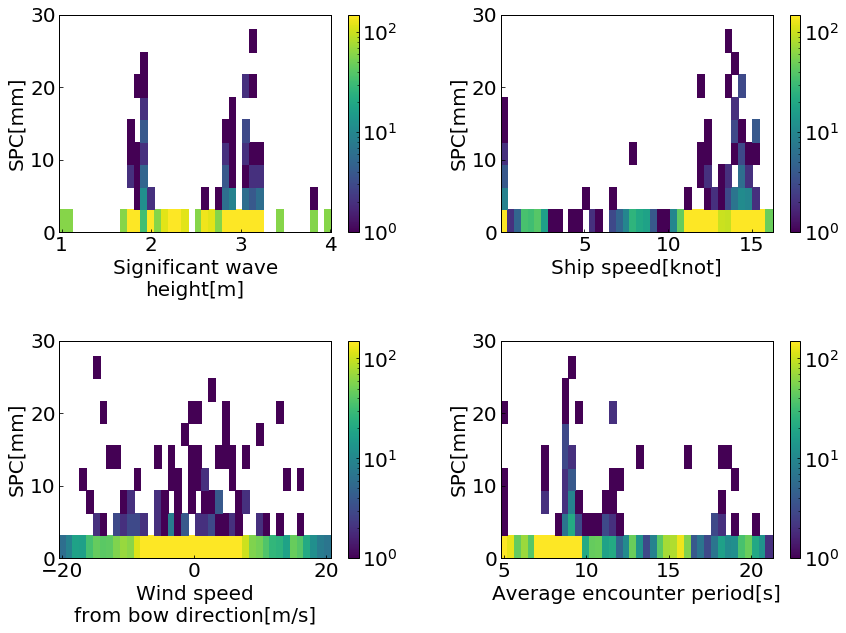

In [57]:
from matplotlib import rcParams,colors

num=2
rcParams.update({'font.size': 10})
fig = plt.figure(figsize=(14, 10), facecolor='w', edgecolor='k')

for i, col in enumerate(extracted_data):
    plt.subplot(2, 2, i+1)
    plt.subplots_adjust(wspace=0.3, hspace=0.5)
    plt.hist2d(df_resampled[col], spc_data,
                   bins=40, norm=colors.LogNorm(vmin=1, vmax=150))
    plt.xlabel(for_2dhist_plot[i], fontsize=20)
    plt.ylabel('SPC[mm]', fontsize=20)
    plt.ylim([0, 30])
    plt.colorbar()
plt.savefig("./2dhist_shirase.png")
plt.show()

In [64]:
df_resampled.to_csv('data.csv', sep='\t')

# いろいろ

In [62]:
shirase_spc = df_resampled

総サンプル数： 944088
しぶき観測あり 46491
割合：4.9244350102956505 %


<Figure size 432x288 with 0 Axes>

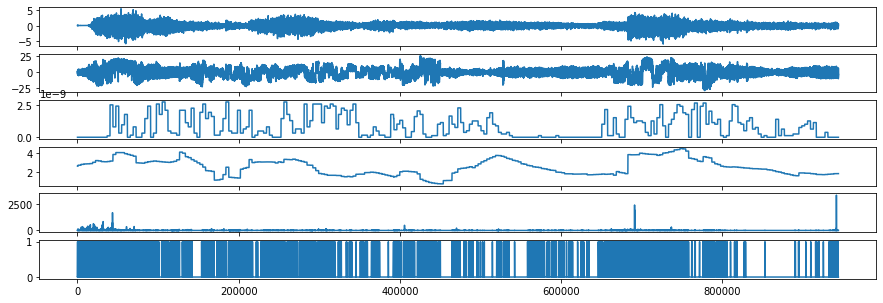

In [63]:
plt.subplots_adjust(wspace=1.1, hspace=2)
show = ['ピッチ (度)', 'relative_wind_y', 'tp', 'swh', 'SPC_flux[mm]', 'label']
plt.figure(figsize=(15, 5))
start = 0
for i, s in enumerate(show):
    #plt.subplots_adjust(wspace=1.1, hspace=0.5)
    plt.subplot(len(show), 1, i+1)
    #plt.plot(np.arange(len(shirase_spc.ix[start:start+7200, :])), shirase_spc.ix[start:start+7200, :][s])
    plt.plot(np.arange(len(shirase_spc)), shirase_spc[s])

print("総サンプル数：", len(shirase_spc['SPC_flux[mm]']))
#th = 4.855319e-07
#tmp = shirase_spc[shirase_spc['tp'] <= th / 3600]['SPC_flux[mm]']
print("しぶき観測あり", len(shirase_spc[shirase_spc['label'] == 1]))
print("割合：{} %".format(len(shirase_spc[shirase_spc['label'] == 1]) / len(shirase_spc['label']) * 100))

In [13]:
# 相対風速が正の数
print("相対風速が正の割合", len(shirase_spc), len(shirase_spc[shirase_spc['relative_wind_y'] >= 0.0]), 
      len(shirase_spc[shirase_spc['relative_wind_y'] >= 0.0]) / len(shirase_spc) * 100, "%")

for i in range(35):
    tmp = shirase_spc[shirase_spc['relative_wind_y'] >= i]
    print("相対風速が", str(i), len(tmp), len(tmp[tmp['label'] != 0.0]), 
          "しぶきが発生する割合", len(tmp[tmp['label'] != 0.0]) / len(tmp) * 100, "%", 
          "しぶきが発生しない割合", len(tmp[tmp['label'] == 0.0]) / len(tmp) * 100, "%")

相対風速が正の割合 2653901 1456385 54.877141234733315 %
相対風速が 0 1456385 262280 しぶきが発生する割合 18.008974275346148 % しぶきが発生しない割合 81.99102572465385 %
相対風速が 1 1347831 248089 しぶきが発生する割合 18.406536131013457 % しぶきが発生しない割合 81.59346386898653 %
相対風速が 2 1234089 233120 しぶきが発生する割合 18.890047638379404 % しぶきが発生しない割合 81.1099523616206 %
相対風速が 3 1118757 217476 しぶきが発生する割合 19.439073900766655 % しぶきが発生しない割合 80.56092609923334 %
相対風速が 4 1006524 201824 しぶきが発生する割合 20.05158346944534 % しぶきが発生しない割合 79.94841653055467 %
相対風速が 5 899926 186119 しぶきが発生する割合 20.6815893751264 % しぶきが発生しない割合 79.31841062487361 %
相対風速が 6 795378 169886 しぶきが発生する割合 21.35915250358949 % しぶきが発生しない割合 78.64084749641052 %
相対風速が 7 698054 153443 しぶきが発生する割合 21.981537244969587 % しぶきが発生しない割合 78.01846275503041 %
相対風速が 8 607017 136739 しぶきが発生する割合 22.5263872346244 % しぶきが発生しない割合 77.4736127653756 %
相対風速が 9 520656 119832 しぶきが発生する割合 23.015580344795797 % しぶきが発生しない割合 76.9844196552042 %
相対風速が 10 442688 103506 しぶきが発生する割合 23.381252710712737 % しぶきが発生しない割合 76.61874728928726 %
相対風速が 11 3

In [14]:
tmp = shirase_spc[shirase_spc['relative_wind_y'] < 0.0]
print("相対風速が", str(i), len(tmp), len(tmp[tmp['label'] != 0.0]), 
          "しぶきが発生する割合", len(tmp[tmp['label'] != 0.0]) / len(tmp) * 100, "%", 
          "しぶきが発生しない割合", len(tmp[tmp['label'] == 0.0]) / len(tmp) * 100, "%")

相対風速が 34 1197516 204637 しぶきが発生する割合 17.08845643816033 % しぶきが発生しない割合 82.91154356183968 %


In [15]:
for i in range(5):
    tmp = shirase_spc[shirase_spc['swh'] >= i]
    print("有義波高", str(i), len(tmp), len(tmp[tmp['label'] != 0.0]), 
          "しぶきが発生する割合", len(tmp[tmp['label'] != 0.0]) / len(tmp) * 100, "%", 
          "しぶきが発生しない割合", len(tmp[tmp['label'] == 0.0]) / len(tmp) * 100, "%")

有義波高 0 2653901 466917 しぶきが発生する割合 17.5936103117637 % しぶきが発生しない割合 82.4063896882363 %
有義波高 1 2632423 466668 しぶきが発生する割合 17.727698018137662 % しぶきが発生しない割合 82.27230198186234 %
有義波高 2 1904536 390664 しぶきが発生する割合 20.512292757921088 % しぶきが発生しない割合 79.48770724207891 %
有義波高 3 1130617 268416 しぶきが発生する割合 23.740665495035014 % しぶきが発生しない割合 76.259334504965 %
有義波高 4 308675 98359 しぶきが発生する割合 31.86490645500931 % しぶきが発生しない割合 68.13509354499068 %
